In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import matplotlib.pyplot as plt
import typing

In [2]:
torch.manual_seed(0)

# Generate random data
n = 1500
inputs = torch.rand((n, 3))
inputs[:, 0] *= 100
inputs[:, 1] *= 100
inputs[:, 1] -= 50
inputs[:, 2] *= 150

w = torch.Tensor([2, -5, 10])
b = torch.Tensor([50])

targets = torch.mv(inputs, w) + b
targets[:] = targets + torch.normal(mean=torch.zeros(n), std=10)
targets = targets.reshape((-1, 1))

inputs[:5], targets[:5]

(tensor([[ 49.6257,  26.8222,  13.2716],
         [ 13.2030, -19.2577,  95.1118],
         [ 49.0093,  39.6445,  68.3442],
         [ 63.2306, -15.1107,  60.2576],
         [  2.2326, -33.1141,  44.0833]]),
 tensor([[ 147.1879],
         [1115.1689],
         [ 643.1873],
         [ 869.9697],
         [ 641.5854]]))

In [3]:
train_dataset = TensorDataset(inputs[:100], targets[:100])
test_dataset = TensorDataset(inputs[100:], targets[100:])

train_dataset[:5], test_dataset[:5]

((tensor([[ 49.6257,  26.8222,  13.2716],
          [ 13.2030, -19.2577,  95.1118],
          [ 49.0093,  39.6445,  68.3442],
          [ 63.2306, -15.1107,  60.2576],
          [  2.2326, -33.1141,  44.0833]]),
  tensor([[ 147.1879],
          [1115.1689],
          [ 643.1873],
          [ 869.9697],
          [ 641.5854]])),
 (tensor([[ 25.8766,   8.9823,  36.0407],
          [ 61.5202,   9.8190,  19.3133],
          [ 58.3249,  21.2965, 104.6873],
          [ 43.7061, -40.9894,  63.4384],
          [ 67.3654, -18.2439, 103.4686]]),
  tensor([[ 431.4573],
          [ 321.2775],
          [1099.5724],
          [ 986.2658],
          [1304.5391]])))

In [4]:
class LinearRegressionModel(nn.Module):
  def __init__(self, n_features: int):
    super().__init__()
    self.w = nn.Parameter(torch.rand((n_features, 1)))
    self.b = nn.Parameter(torch.rand(1))

  def forward(self, X: torch.Tensor):
    return torch.matmul(X, self.w) + self.b

def test_model(model, test_dl: Dataset, loss_fn: typing.Callable):
  model.eval()

  test_loss = 0
  test_loss_n = 0

  with torch.inference_mode():
    for x, y in test_dl:
      pred = model(x)
      loss = loss_fn(pred, y)

      test_loss += loss
      test_loss_n += 1
  return float((test_loss / test_loss_n).numpy())

In [5]:
BATCH_SIZE = 100
LR = 1e-5
EPOCHS = 100
train_dl = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_dl = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True)

model = LinearRegressionModel(3)
opt = torch.optim.SGD(model.parameters(), lr = LR)
loss_fn = F.mse_loss

epoch_losses = []
epoch_test_losses = []

for epoch in range(EPOCHS):
  epoch_loss = 0
  epoch_iters = 0

  model.train()
  opt.zero_grad()
  for x, y in train_dl:
    pred = model(x)
    loss = loss_fn(pred, y)

    # Perform gradient descent
    loss.backward()
    opt.step()

    epoch_loss += loss
    epoch_iters += 1

  epoch_loss /= epoch_iters
  epoch_loss = epoch_loss.detach().numpy()
  epoch_losses.append(epoch_loss)

  test_loss = test_model(model, test_dl, loss_fn) # switched to train mode
  epoch_test_losses.append(test_loss)

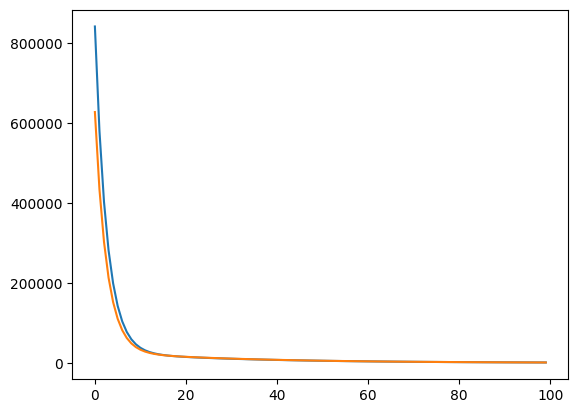

In [6]:
plt.plot(epoch_losses)
plt.plot(epoch_test_losses)
plt.show()

In [7]:
model.w, model.b

(Parameter containing:
 tensor([[ 2.8012],
         [-3.9780],
         [10.1054]], requires_grad=True),
 Parameter containing:
 tensor([1.0038], requires_grad=True))